# K-means (Clustering)
Clustering algorithm the dice rolling way.

This is inspired by [StatQuest: K-means clustering](https://youtu.be/4b5d3muPQmA)

## Setup

In [128]:
import math
import einops
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import Counter

%matplotlib inline

## Fake data

In [129]:
torch.manual_seed(0xbad)

n_clusters = 6
n_samples = 250
clusters = []
centroids = torch.rand(n_clusters, 2) * 100 - 50
for centroid in centroids:
    clusters.append(MultivariateNormal(centroid, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,)))

data = torch.cat(clusters)

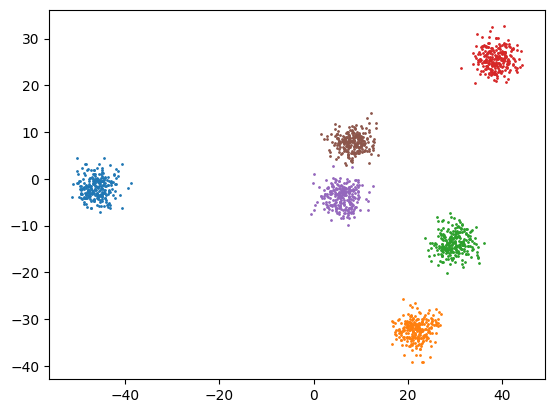

In [130]:
def plot_data(clusters, ax=None):
    if ax is None: _, ax = plt.subplots()
    for cluster in clusters:
        ax.scatter(cluster[:,0], cluster[:,1], s=1)

_ = plot_data(clusters)

## Code
Chose `k` random points as centroids of our `k` clusters, greedily assign each point to the closest centroid's cluster. Assign the new centroid to the mean of each cluster and repeat until we reach an equilibrium.

There is no guarantee for this solution to be any good, we selected the initial centoids at random. So the idea is to repeat the process a bunch of time, and stick with the solution that minimize sum of the clusters variance.

In [131]:
@torch.no_grad()
def kmeans(data, n_clusters=n_clusters, n_iters=10):
    num_samples = data.shape[0]

    def f():
        old_cluster = torch.zeros(num_samples)
        centroids = data[torch.randperm(num_samples)[:n_clusters], :]
        while True: # repeat until stable
            distances = torch.cdist(data, centroids)
            clusters = distances.argmin(dim=1)
            if old_cluster.equal(clusters): return clusters
            old_cluster = clusters
            for i in range(n_clusters): # can we vectorize that?
                centroids[i] = data[clusters == i, :].mean(dim=0)

    def variance(clusters):
        return sum([data[clusters == i, :].var(dim=0).sum() for i in range(n_clusters)])

    return min([f() for _ in range(n_iters)], key=variance)


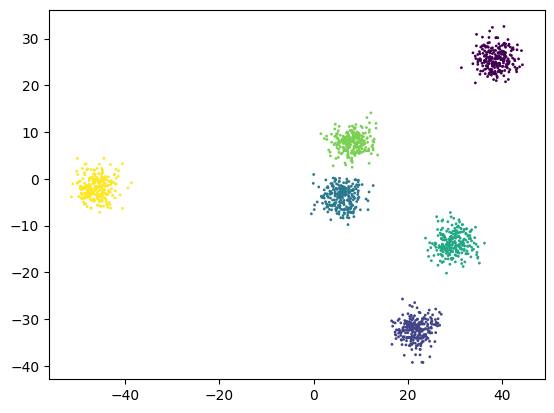

In [132]:
clusters = kmeans(data)
_ = plt.scatter(data[:, 0], data[:, 1], c=clusters, s=1)

## Animation

In [133]:
@torch.no_grad()
def km(data, n_clusters=n_clusters, n_iters=10):
    num_samples = data.shape[0]

    def f():
        all_clusters = []
        old_cluster = torch.zeros(num_samples)
        centroids = data[torch.randperm(num_samples)[:n_clusters], :]
        while True: # repeat until stable
            distances = torch.cdist(data, centroids)
            clusters = distances.argmin(dim=1)
            all_clusters.append(clusters)
            if old_cluster.equal(clusters): return all_clusters
            old_cluster = clusters
            for i in range(n_clusters): # can we vectorize that?
                centroids[i] = data[clusters == i, :].mean(dim=0)

    def variance(all_clusters):
        clusters = all_clusters[-1]
        return sum([data[clusters == i, :].var(dim=0).sum() for i in range(n_clusters)])

    return sorted([f() for _ in range(n_iters)], key=variance, reverse=True)

def f(all_clusters):
    d0, d1 = data[:, 0], data[:, 1]
    def update(frame):
        clusters = all_clusters[frame]
        ax.clear()
        ax.scatter(d0, d1, c=clusters)
    return update
     
all_clusters = [ac for aac in km(data) for ac in aac]
fig, ax = plt.subplots()
ani = FuncAnimation(fig, f(all_clusters), frames=len(all_clusters), interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())